# Exploratory Data Analysis - Shopee Product Matching

This notebook performs initial exploration of the Shopee product matching dataset.

In [56]:
from torch.nn import functional as F
import torchvision.models as models
from torchvision import transforms
from difflib import SequenceMatcher
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import torch
import re

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up paths
data_dir = Path('../shopee-product-matching-data')
train_csv = data_dir / 'train.csv'
test_csv = data_dir / 'test.csv'
train_images_dir = data_dir / 'train_images'
test_images_dir = data_dir / 'test_images'

## 1. Load Training Data

In [47]:
train_df = pd.read_csv(train_csv)
print(f"Training data shape: {train_df.shape}")
print(f"\nColumn names and types:")
print(train_df.dtypes)
print(f"\nFirst few rows:")
train_df.head()

Training data shape: (34250, 5)

Column names and types:
posting_id       str
image            str
image_phash      str
title            str
label_group    int64
dtype: object

First few rows:


,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


## 2. Load Test Data

In [48]:
test_df = pd.read_csv(test_csv)
print(f"Test data shape: {test_df.shape}")
print(f"\nFirst few rows:")
test_df.head()

Test data shape: (3, 4)

First few rows:


,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


## 3. Check for Missing Values

In [49]:
print("Training data - Missing values:")
print(train_df.isnull().sum())
print(f"\nTest data - Missing values:")
print(test_df.isnull().sum())

Training data - Missing values:
posting_id     0
image          0
image_phash    0
title          0
label_group    0
dtype: int64

Test data - Missing values:
posting_id     0
image          0
image_phash    0
title          0
dtype: int64


## 4. Basic Statistics

In [50]:
print("Training data statistics:")
print(train_df.describe())
print(f"\nUnique values per column:")
print(train_df.nunique())

Training data statistics:
        label_group
count  3.425000e+04
mean   2.128611e+09
std    1.234630e+09
min    2.580470e+05
25%    1.050720e+09
50%    2.120410e+09
75%    3.187910e+09
max    4.294197e+09

Unique values per column:
posting_id     34250
image          32412
image_phash    28735
title          33117
label_group    11014
dtype: int64


## 5. Explore Images

In [51]:
# Check training images
train_images = list(train_images_dir.glob('*.jpg'))
print(f"Number of training images: {len(train_images)}")
print(f"First few images: {[img.name for img in train_images[:5]]}")

# Check test images
test_images = list(test_images_dir.glob('*.jpg'))
print(f"\nNumber of test images: {len(test_images)}")
print(f"First few images: {[img.name for img in test_images[:5]]}")

Number of training images: 32412
First few images: ['2acfffc7636789596041b426cbd345af.jpg', 'a68eb1b5a0c1c326d7b6ef42cfddaf69.jpg', 'effc540299fe3a4b132802f0a9547a4e.jpg', '53bd87d83a50740667ecd736bb067388.jpg', '5799f0087fb40852b8e52738dfe74da9.jpg']

Number of test images: 3
First few images: ['0008377d3662e83ef44e1881af38b879.jpg', '0007585c4d0f932859339129f709bfdc.jpg', '0006c8e5462ae52167402bac1c2e916e.jpg']


## 6. Visualize Sample Images

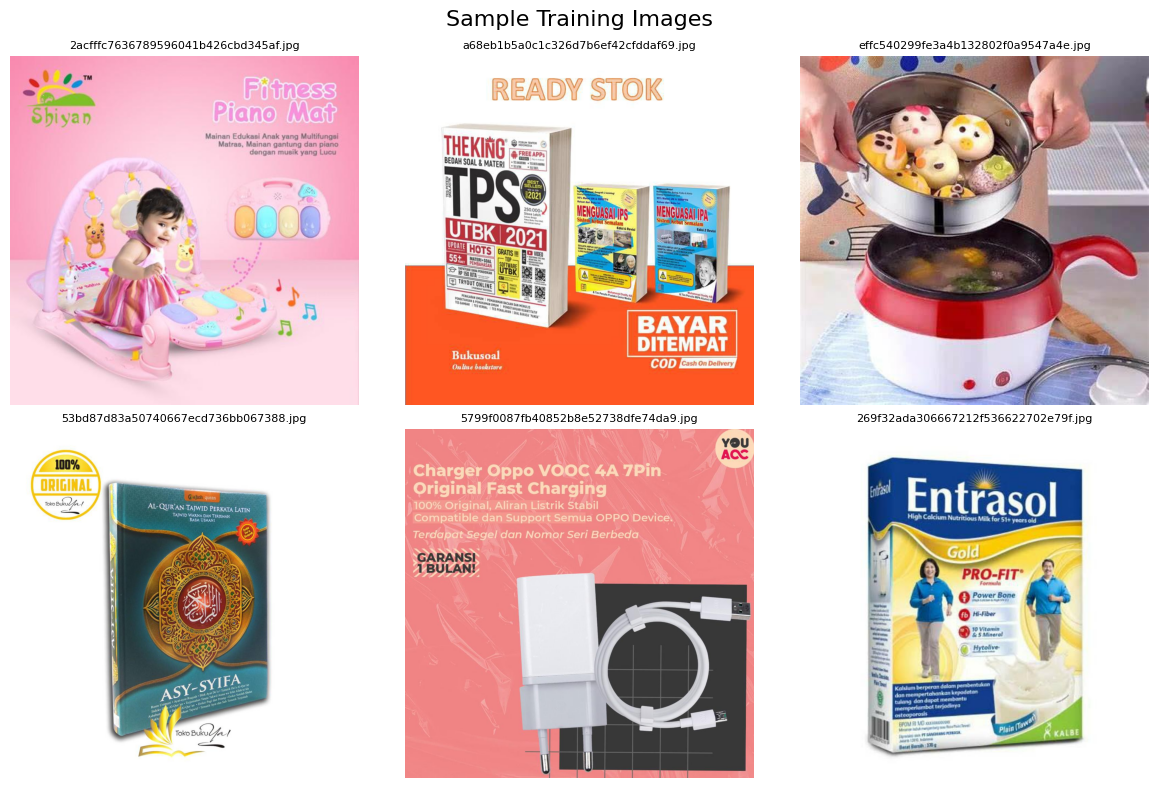

Successfully displayed 6 images


In [52]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Sample Training Images', fontsize=16)

count = 0
for idx, ax in enumerate(axes.flat):
    if count < len(train_images):
        try:
            img = Image.open(train_images[count])
            ax.imshow(img)
            ax.set_title(train_images[count].name, fontsize=8)
            ax.axis('off')
            count += 1
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading image', ha='center', va='center')
            ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Successfully displayed {count} images")

## 7. Data Distribution Analysis

In [53]:
# Check for class imbalance or other patterns
print("Value counts for key columns:\n")

# Check label_group distribution
print("Label Group Distribution:")
print(train_df['label_group'].value_counts().head(20))
print(f"\nTotal unique label groups: {train_df['label_group'].nunique()}")

# Check title length distribution
print(f"\n\nTitle Statistics:")
train_df['title_length'] = train_df['title'].str.len()
print(train_df['title_length'].describe())

# Check image format
print(f"\n\nImage Column Sample:")
print(train_df['image'].head(10))

Value counts for key columns:

Label Group Distribution:
label_group
1141798720    51
3113678103    51
562358068     51
3627744656    51
994676122     51
1163569239    51
159351600     51
3206118280    49
1166650192    46
1733221456    46
1091404026    45
3489985175    41
1237550763    37
1746655739    36
731330024     35
452508504     35
2008989859    35
4184214313    35
871679006     34
66247839      34
Name: count, dtype: int64

Total unique label groups: 11014


Title Statistics:
count    34250.000000
mean        56.163474
std         25.100492
min          5.000000
25%         36.000000
50%         53.000000
75%         73.000000
max        357.000000
Name: title_length, dtype: float64


Image Column Sample:
0    0000a68812bc7e98c42888dfb1c07da0.jpg
1    00039780dfc94d01db8676fe789ecd05.jpg
2    000a190fdd715a2a36faed16e2c65df7.jpg
3    00117e4fc239b1b641ff08340b429633.jpg
4    00136d1cf4edede0203f32f05f660588.jpg
5    0013e7355ffc5ff8fb1ccad3e42d92fe.jpg
6    00144a49c56599d45354

## 8.Distribution Analysis (4 charts):
- Top 20 product groups by count
- Title length distribution (mostly 30-80 chars)
- Group size distribution (most groups have 2-51 products)
- Words per title distribution (avg 9.4 words)

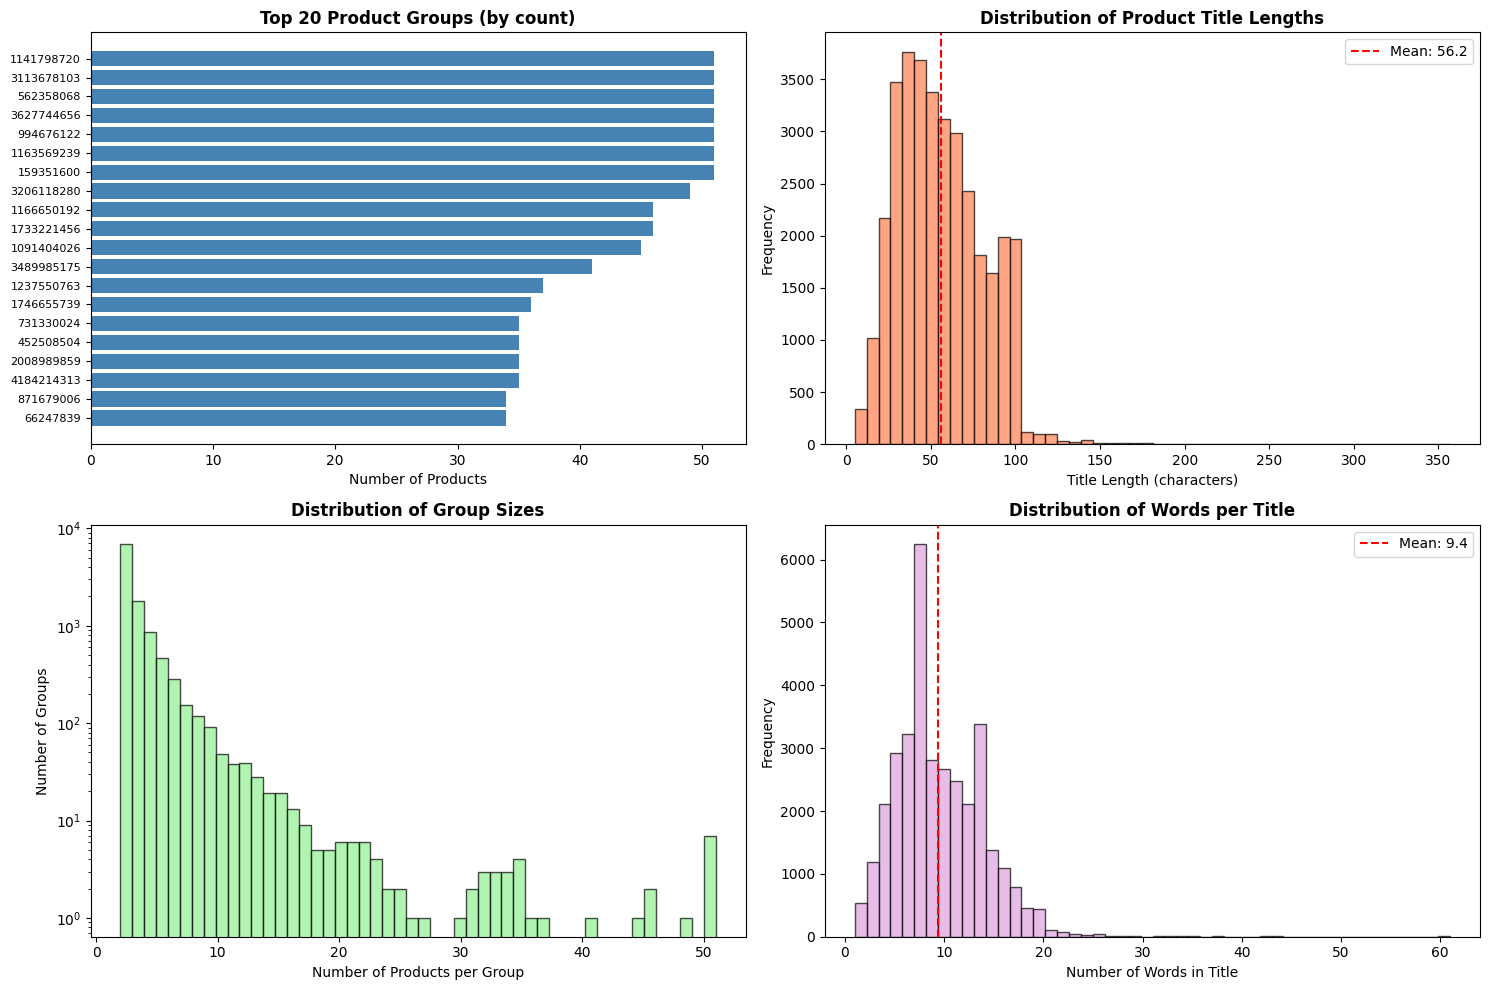

SUMMARY STATISTICS

Label Group Statistics:
  - Total unique groups: 11014
  - Min products per group: 2
  - Max products per group: 51
  - Avg products per group: 3.11

Title Statistics:
  - Min length: 5 chars
  - Max length: 357 chars
  - Average length: 56.16 chars
  - Average words: 9.41
  - Median words: 9


In [54]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Top 20 Label Groups
top_labels = train_df['label_group'].value_counts().head(20)
axes[0, 0].barh(range(len(top_labels)), top_labels.values, color='steelblue')
axes[0, 0].set_yticks(range(len(top_labels)))
axes[0, 0].set_yticklabels(top_labels.index, fontsize=8)
axes[0, 0].set_xlabel('Number of Products')
axes[0, 0].set_title('Top 20 Product Groups (by count)', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()

# 2. Title Length Distribution
axes[0, 1].hist(train_df['title_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Title Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Product Title Lengths', fontsize=12, fontweight='bold')
axes[0, 1].axvline(train_df['title_length'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["title_length"].mean():.1f}')
axes[0, 1].legend()

# 3. Label Group Size Distribution (log scale)
label_counts = train_df['label_group'].value_counts().values
axes[1, 0].hist(label_counts, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Products per Group')
axes[1, 0].set_ylabel('Number of Groups')
axes[1, 0].set_title('Distribution of Group Sizes', fontsize=12, fontweight='bold')
axes[1, 0].set_yscale('log')

# 4. Text Statistics
word_counts = train_df['title'].str.split().str.len()
axes[1, 1].hist(word_counts, bins=50, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Number of Words in Title')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Words per Title', fontsize=12, fontweight='bold')
axes[1, 1].axvline(word_counts.mean(), color='red', linestyle='--', label=f'Mean: {word_counts.mean():.1f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"\nLabel Group Statistics:")
print(f"  - Total unique groups: {train_df['label_group'].nunique()}")
print(f"  - Min products per group: {train_df['label_group'].value_counts().min()}")
print(f"  - Max products per group: {train_df['label_group'].value_counts().max()}")
print(f"  - Avg products per group: {train_df['label_group'].value_counts().mean():.2f}")

print(f"\nTitle Statistics:")
print(f"  - Min length: {train_df['title_length'].min()} chars")
print(f"  - Max length: {train_df['title_length'].max()} chars")
print(f"  - Average length: {train_df['title_length'].mean():.2f} chars")
print(f"  - Average words: {word_counts.mean():.2f}")
print(f"  - Median words: {word_counts.median():.0f}")

## 9. Additional EDA Opportunities

Below are some advanced analyses you could perform:

1. **Image Analysis**
   - Perceptual Hash (pHash) distribution - check for duplicate images
   - Image dimensions and aspect ratios
   - Color histograms and visual similarity

2. **Text Analysis**
   - Most common words/products in titles
   - Language patterns (appears to be Indonesian products)
   - Substring matching to detect similar products
   - TF-IDF to find distinguishing terms

3. **Group Analysis**
   - Analyze which products are grouped together (same label_group)
   - Look for patterns in grouped products (similar titles, same images, etc.)
   - Identify easy vs hard groups to match

4. **Data Quality**
   - Check for duplicate titles with different images
   - Find products with similar pHash values
   - Identify potential labeling errors

5. **Feature Engineering**
   - Character n-grams for string similarity
   - Image embedding distances
   - Statistical features from product descriptions

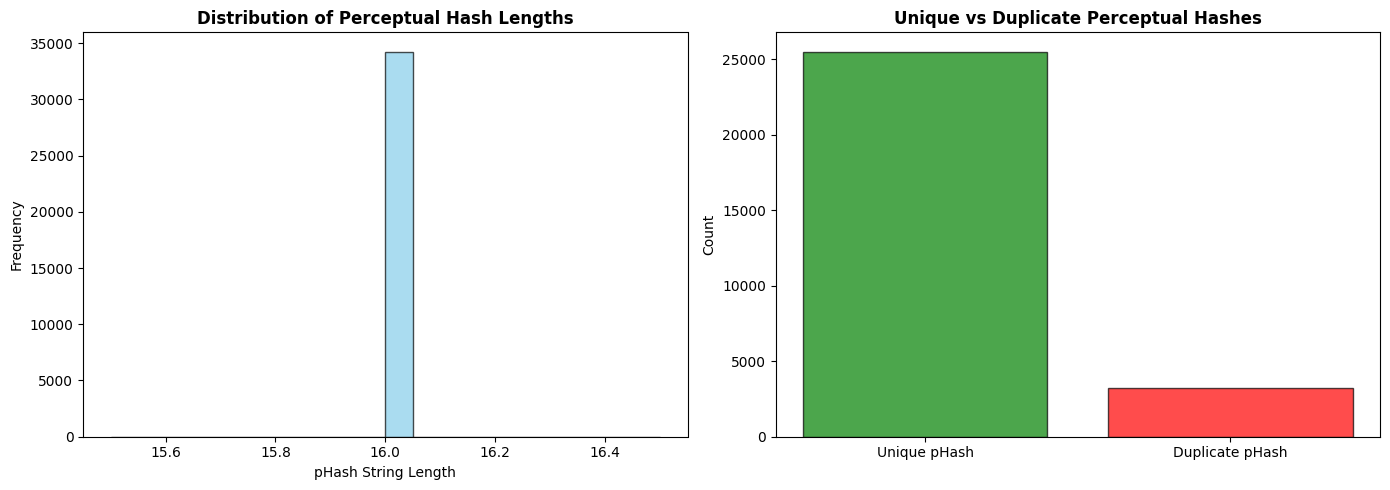


IMAGE & PERCEPTUAL HASH ANALYSIS

Perceptual Hash (pHash) Statistics:
  - Unique hashes: 28735
  - Total images: 34250
  - Images with duplicate pHash: 3229
  - Total duplicate instances: 5515

Top 10 Most Common pHashes (potential similar images):
  1. pHash: fad28daa2ad05595 - 26 images
  2. pHash: d0c0ea37bd9acce0 - 20 images
  3. pHash: be12e12f9ec1e198 - 17 images
  4. pHash: e992966d4ba49761 - 16 images
  5. pHash: f6d98134b904b56b - 16 images
  6. pHash: ba96cc48cc63c56b - 14 images
  7. pHash: 84563f696135c79a - 13 images
  8. pHash: def6e14b4a398885 - 13 images
  9. pHash: ada4c4781f93686e - 12 images
  10. pHash: 9e8966c3ad4ecc62 - 12 images

Sample: Checking if duplicate pHashes belong to same label_group:
  pHash fad28daa2ad05595: 26 images, 1 different label_groups
    Label groups: [997220911]
  pHash d0c0ea37bd9acce0: 20 images, 3 different label_groups
    Label groups: [4198148727 2403374241 1960893869]
  pHash be12e12f9ec1e198: 17 images, 1 different label_groups
   

In [55]:
# Perceptual Hash and Image Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. pHash Length Distribution
phash_lengths = train_df['image_phash'].str.len()
axes[0].hist(phash_lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('pHash String Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Perceptual Hash Lengths', fontsize=12, fontweight='bold')

# 2. Duplicate pHash Analysis
phash_counts = train_df['image_phash'].value_counts()
duplicate_phashes = (phash_counts > 1).sum()
axes[1].bar(['Unique pHash', 'Duplicate pHash'], 
            [len(phash_counts) - duplicate_phashes, duplicate_phashes],
            color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Count')
axes[1].set_title('Unique vs Duplicate Perceptual Hashes', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("IMAGE & PERCEPTUAL HASH ANALYSIS")
print("=" * 60)
print(f"\nPerceptual Hash (pHash) Statistics:")
print(f"  - Unique hashes: {len(phash_counts)}")
print(f"  - Total images: {len(train_df)}")
print(f"  - Images with duplicate pHash: {(phash_counts > 1).sum()}")
print(f"  - Total duplicate instances: {phash_counts.sum() - len(phash_counts)}")

print(f"\nTop 10 Most Common pHashes (potential similar images):")
top_phash = phash_counts.head(10)
for idx, (phash, count) in enumerate(top_phash.items(), 1):
    print(f"  {idx}. pHash: {phash} - {count} images")

# Check if same pHash has same label_group
print(f"\nSample: Checking if duplicate pHashes belong to same label_group:")
for phash, count in phash_counts[phash_counts > 1].head(3).items():
    label_groups = train_df[train_df['image_phash'] == phash]['label_group'].unique()
    print(f"  pHash {phash}: {count} images, {len(label_groups)} different label_groups")
    if len(label_groups) <= 3:
        print(f"    Label groups: {label_groups}")

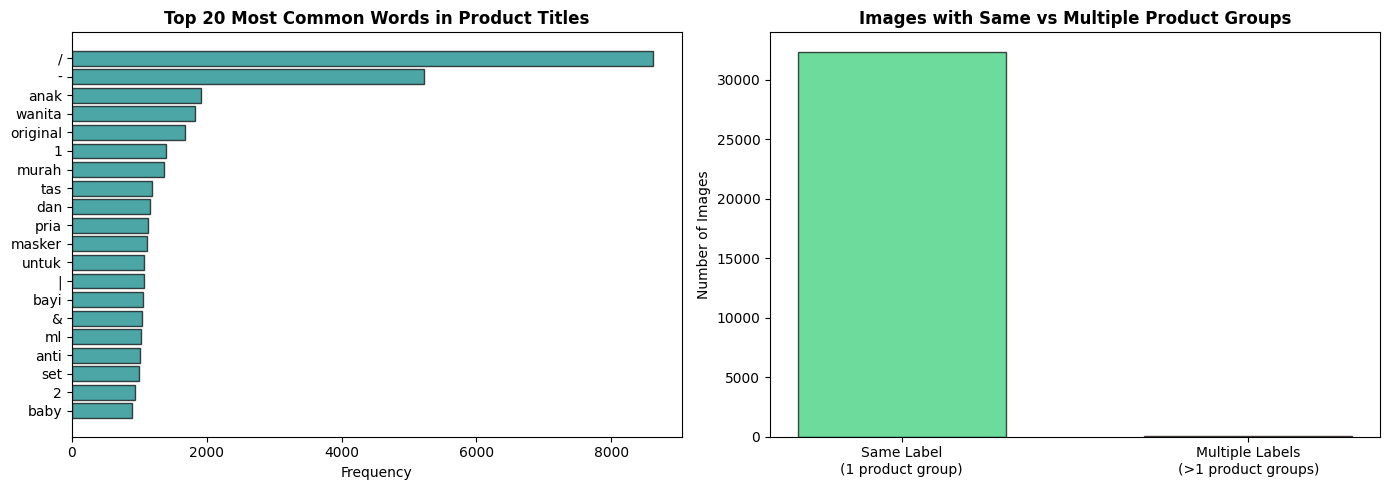


TEXT ANALYSIS

Top 20 Most Common Words:
   1. '/' - 8,616 times
   2. '-' - 5,221 times
   3. 'anak' - 1,916 times
   4. 'wanita' - 1,820 times
   5. 'original' - 1,681 times
   6. '1' - 1,400 times
   7. 'murah' - 1,363 times
   8. 'tas' - 1,192 times
   9. 'dan' - 1,157 times
  10. 'pria' - 1,122 times
  11. 'masker' - 1,111 times
  12. 'untuk' - 1,068 times
  13. '|' - 1,066 times
  14. 'bayi' - 1,061 times
  15. '&' - 1,042 times
  16. 'ml' - 1,028 times
  17. 'anti' - 1,018 times
  18. 'set' - 992 times
  19. '2' - 931 times
  20. 'baby' - 887 times


Image Reuse Analysis:
  - Total unique images: 32412
  - Images reused across product groups: 46
  - Max label_groups for single image: 3

Top 5 Images used in most different product groups:
  1. Image: 133bc0babbcefd126c3ff97e3df104a6.jpg - Used in 3 groups
  2. Image: a5f474ae2def233110a9a05dc2e64e34.jpg - Used in 3 groups
  3. Image: 0c1da0c6bab51f1fe7df75ef060fc77d.jpg - Used in 2 groups
  4. Image: 0cca4afba97e106abd0843ce7288

In [57]:
# Extract words from all titles
all_words = []
for title in train_df['title']:
    # Simple tokenization: split by whitespace and convert to lowercase
    words = title.lower().split()
    all_words.extend(words)

# Count word frequencies
word_counts = Counter(all_words)
top_words = dict(word_counts.most_common(20))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Most common words
words_list = list(top_words.keys())
counts_list = list(top_words.values())
axes[0].barh(words_list, counts_list, color='teal', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Most Common Words in Product Titles', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# Same image, different labels analysis
same_image_diff_label = train_df.groupby('image')['label_group'].nunique()
multi_label_images = (same_image_diff_label > 1).sum()

axes[1].bar(['Same Label\n(1 product group)', 'Multiple Labels\n(>1 product groups)'],
            [len(same_image_diff_label) - multi_label_images, multi_label_images],
            color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black', width=0.6)
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Images with Same vs Multiple Product Groups', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("TEXT ANALYSIS")
print("=" * 60)
print(f"\nTop 20 Most Common Words:")
for idx, (word, count) in enumerate(top_words.items(), 1):
    print(f"  {idx:2d}. '{word}' - {count:,} times")

print(f"\n\nImage Reuse Analysis:")
print(f"  - Total unique images: {len(same_image_diff_label)}")
print(f"  - Images reused across product groups: {multi_label_images}")
print(f"  - Max label_groups for single image: {same_image_diff_label.max()}")

# Show examples of images used in multiple groups
if multi_label_images > 0:
    print(f"\nTop 5 Images used in most different product groups:")
    top_reused = same_image_diff_label.nlargest(5)
    for idx, (image, num_labels) in enumerate(top_reused.items(), 1):
        labels = train_df[train_df['image'] == image]['label_group'].unique()
        print(f"  {idx}. Image: {image} - Used in {num_labels} groups")

## 10. String Similarity Analysis

String Similarity Analysis
Total pairwise comparisons: 83,751

Similarity Statistics:
  Mean similarity: 0.544
  Median similarity: 0.513
  Std dev: 0.202
  Min: 0.026
  Max: 1.000
  10th percentile: 0.304
  25th percentile: 0.396
  50th percentile: 0.513
  75th percentile: 0.674
  90th percentile: 0.849


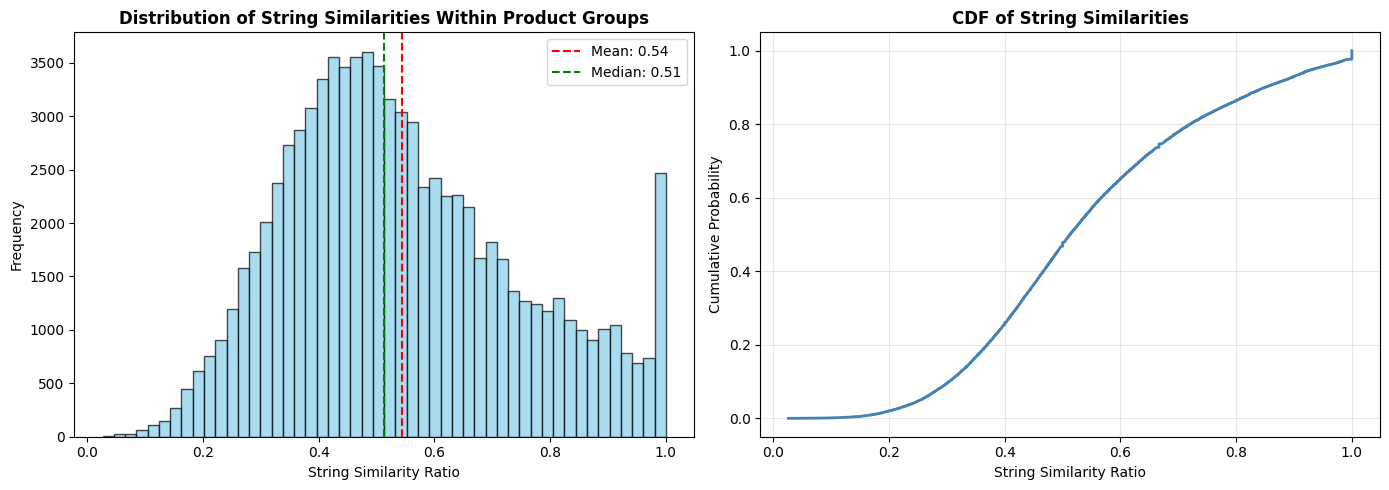

In [58]:
def calculate_similarity_ratios(group_titles):
    """Calculate all pairwise similarity ratios for titles in a group"""
    if len(group_titles) < 2:
        return []
    
    ratios = []
    for t1, t2 in combinations(group_titles, 2):
        ratio = SequenceMatcher(None, t1.lower(), t2.lower()).ratio()
        ratios.append(ratio)
    return ratios

# Calculate similarities for each group
all_similarities = []
for group_id, group_data in train_df.groupby('label_group'):
    titles = group_data['title'].tolist()
    sims = calculate_similarity_ratios(titles)
    all_similarities.extend(sims)

all_similarities = np.array(all_similarities)

print(f"String Similarity Analysis")
print(f"="*60)
print(f"Total pairwise comparisons: {len(all_similarities):,}")
print(f"\nSimilarity Statistics:")
print(f"  Mean similarity: {all_similarities.mean():.3f}")
print(f"  Median similarity: {np.median(all_similarities):.3f}")
print(f"  Std dev: {all_similarities.std():.3f}")
print(f"  Min: {all_similarities.min():.3f}")
print(f"  Max: {all_similarities.max():.3f}")

# Percentiles
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    print(f"  {p}th percentile: {np.percentile(all_similarities, p):.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(all_similarities, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(all_similarities.mean(), color='red', linestyle='--', label=f'Mean: {all_similarities.mean():.2f}')
axes[0].axvline(np.median(all_similarities), color='green', linestyle='--', label=f'Median: {np.median(all_similarities):.2f}')
axes[0].set_xlabel('String Similarity Ratio')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of String Similarities Within Product Groups', fontsize=12, fontweight='bold')
axes[0].legend()

# CDF
sorted_sims = np.sort(all_similarities)
cdf = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
axes[1].plot(sorted_sims, cdf, linewidth=2, color='steelblue')
axes[1].set_xlabel('String Similarity Ratio')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('CDF of String Similarities', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. N-gram Analysis for Product Type Patterns


N-gram Analysis

Top 20 Bigrams (word pairs):
   1. 'jam tangan' - 436 times
   2. 'in 1' - 328 times
   3. 'kaos kaki' - 257 times
   4. 'sarung tangan' - 238 times
   5. 'tas selempang' - 216 times
   6. 'anti air' - 211 times
   7. 'masker kain' - 197 times
   8. 'make up' - 170 times
   9. '1 kg' - 170 times
  10. 'garansi resmi' - 156 times
  11. '100 ml' - 154 times
  12. 'tempered glass' - 150 times
  13. 'anak perempuan' - 139 times
  14. 'untuk wanita' - 139 times
  15. 'lampu led' - 137 times
  16. 'ikat rambut' - 134 times
  17. 'xiaomi redmi' - 133 times
  18. 'celana dalam' - 127 times
  19. 'stainless steel' - 119 times
  20. 'mainan anak' - 114 times

Top 15 Trigrams (word triplets):
   1. '2 in 1' - 104 times
   2. 'jam tangan wanita' - 83 times
   3. 'jam tangan pria' - 81 times
   4. 'tas selempang wanita' - 81 times
   5. '3 in 1' - 79 times
   6. 'some by mi' - 75 times
   7. 'xiaomi redmi note' - 65 times
   8. 'gluta collagen soap' - 50 times
   9. '11 pro max' -

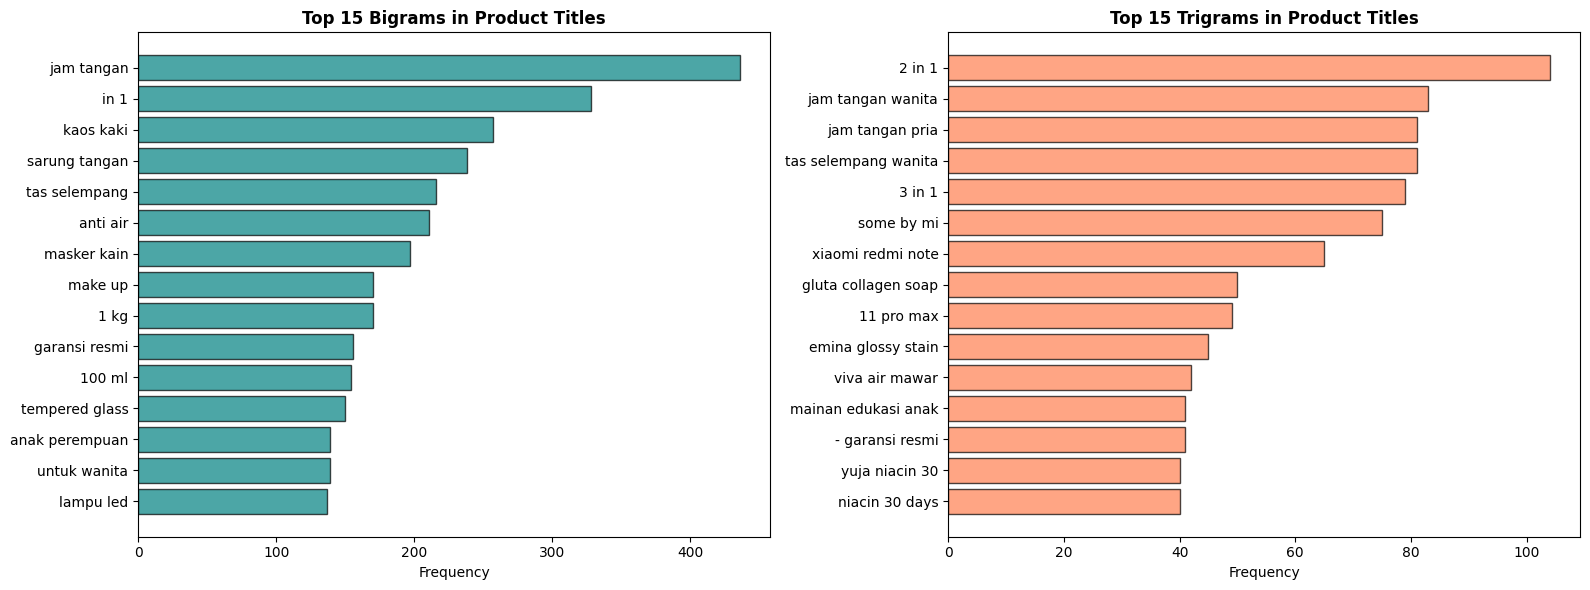

In [59]:
# Extract n-grams from titles
def extract_ngrams(text, n=2):
    """Extract n-grams from text"""
    tokens = text.lower().split()
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# Extract bigrams and trigrams
bigrams = []
trigrams = []

for title in train_df['title']:
    bigrams.extend(extract_ngrams(title, n=2))
    trigrams.extend(extract_ngrams(title, n=3))

bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

print(f"\nN-gram Analysis")
print(f"="*60)
print(f"\nTop 20 Bigrams (word pairs):")
for idx, (bigram, count) in enumerate(bigram_counts.most_common(20), 1):
    print(f"  {idx:2d}. '{bigram}' - {count:,} times")

print(f"\nTop 15 Trigrams (word triplets):")
for idx, (trigram, count) in enumerate(trigram_counts.most_common(15), 1):
    print(f"  {idx:2d}. '{trigram}' - {count:,} times")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bigrams
top_bigrams = dict(bigram_counts.most_common(15))
axes[0].barh(list(top_bigrams.keys()), list(top_bigrams.values()), color='teal', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 15 Bigrams in Product Titles', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# Trigrams
top_trigrams = dict(trigram_counts.most_common(15))
axes[1].barh(list(top_trigrams.keys()), list(top_trigrams.values()), color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 15 Trigrams in Product Titles', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 12. Temporal Pattern Analysis (Posting ID)


Temporal Pattern Analysis (from Posting ID)

Sample Posting IDs:
['train_129225211', 'train_3386243561', 'train_2288590299', 'train_2406599165', 'train_3369186413', 'train_2464356923', 'train_1802986387', 'train_1806152124', 'train_86570404', 'train_831680791', 'train_1598329973', 'train_2496690777', 'train_2771755203', 'train_998568945', 'train_4287573913', 'train_4196427721', 'train_3009013664', 'train_3054371232', 'train_2985955659', 'train_2961381387']

Posting ID Numeric Range:
  Min: 84,753
  Max: 4,294,874,773
  Range: 4,294,790,020

  ⚠ Posting ID appears to potentially encode timestamps
    129225211: Could be 1974-02-04 15:53:31 (seconds) or 1970-01-02 11:53:45.211000 (milliseconds)
    3386243561: Could be 2077-04-21 15:12:41 (seconds) or 1970-02-09 04:37:23.561000 (milliseconds)
    2288590299: Could be 2042-07-10 07:31:39 (seconds) or 1970-01-27 11:43:10.299000 (milliseconds)
    2406599165: Could be 2046-04-06 03:46:05 (seconds) or 1970-01-28 20:29:59.165000 (millisecond

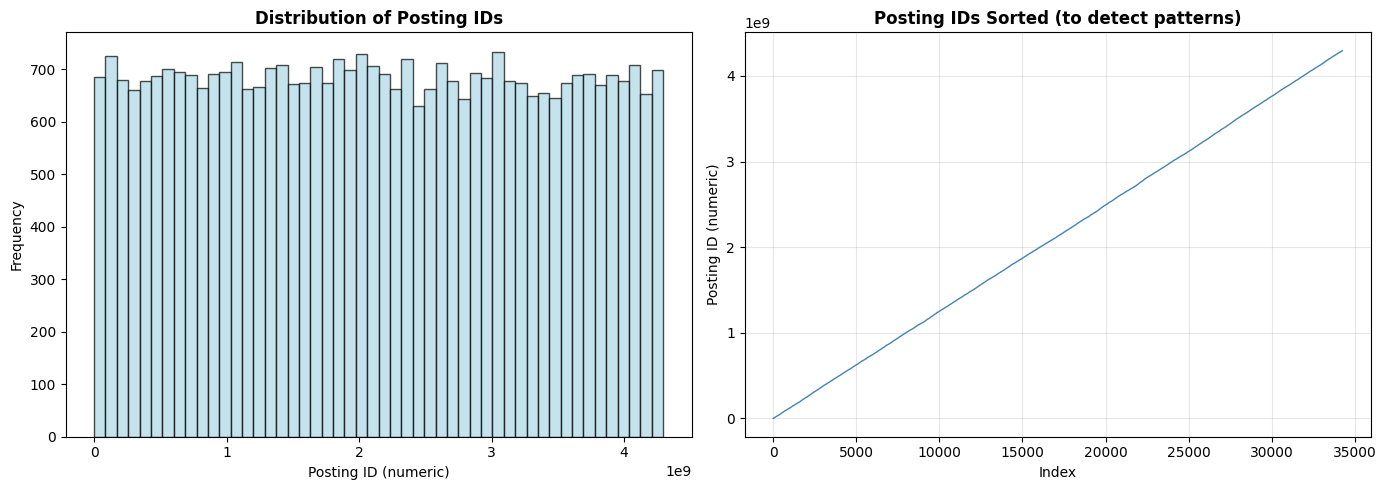


Posting ID Statistics:
count    3.425000e+04
mean     2.140074e+09
std      1.239258e+09
min      8.475300e+04
25%      1.068723e+09
50%      2.126323e+09
75%      3.206588e+09
max      4.294875e+09
Name: posting_id_numeric, dtype: float64


In [60]:
# Analyze posting_id for temporal patterns
print(f"\nTemporal Pattern Analysis (from Posting ID)")
print(f"="*60)

# Sample posting IDs
print(f"\nSample Posting IDs:")
print(train_df['posting_id'].head(20).tolist())

# Extract numeric part
train_df['posting_id_numeric'] = train_df['posting_id'].str.replace('train_', '').astype(np.int64)

print(f"\nPosting ID Numeric Range:")
print(f"  Min: {train_df['posting_id_numeric'].min():,}")
print(f"  Max: {train_df['posting_id_numeric'].max():,}")
print(f"  Range: {train_df['posting_id_numeric'].max() - train_df['posting_id_numeric'].min():,}")

# Check if it encodes date (10 digits might be epoch timestamp)
if train_df['posting_id_numeric'].max() > 1e9:
    print(f"\n  ⚠ Posting ID appears to potentially encode timestamps")
    # Try to convert assuming Unix timestamp in milliseconds or seconds
    sample_ids = train_df['posting_id_numeric'].head(5)
    for pid in sample_ids:
        # Try seconds
        try:
            date_sec = pd.Timestamp(pid, unit='s')
            date_ms = pd.Timestamp(pid, unit='ms')
            print(f"    {pid}: Could be {date_sec} (seconds) or {date_ms} (milliseconds)")
        except:
            pass

# Distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(train_df['posting_id_numeric'], bins=50, color='lightblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Posting ID (numeric)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Posting IDs', fontsize=12, fontweight='bold')

# Sorted
axes[1].plot(sorted(train_df['posting_id_numeric'].values), linewidth=1, color='steelblue')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Posting ID (numeric)')
axes[1].set_title('Posting IDs Sorted (to detect patterns)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPosting ID Statistics:")
print(train_df['posting_id_numeric'].describe())

## 13. Image Embeddings using ResNet50 (Pre-trained)
- Image embeddings using torchvision ResNet50
- This will extract visual features and compute similarity

In [61]:
print(f"\nImage Embeddings & Visual Similarity Analysis")
print(f"="*60)
print(f"Loading pre-trained ResNet50 model...")

# Load pre-trained ResNet50
device = torch.device('cpu')
model = models.resnet50(pretrained=True).to(device)
model.eval()

# Remove the last classification layer to get embeddings
model = torch.nn.Sequential(*list(model.children())[:-1])

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print(f"✓ Model loaded successfully")
print(f"Using device: {device}")


Image Embeddings & Visual Similarity Analysis
Loading pre-trained ResNet50 model...
✓ Model loaded successfully
Using device: cpu


Extracting image embeddings (this may take a minute)...
  Processing 0/500...
  Processing 100/500...
  Processing 200/500...
  Processing 300/500...
  Processing 400/500...
✓ Extracted 500 embeddings (failed: 0)
Embedding shape: (500, 2048)

Image Similarity Statistics (within groups):
  Total comparisons: 22
  Mean similarity: 0.872
  Median similarity: 0.859
  Std dev: 0.076


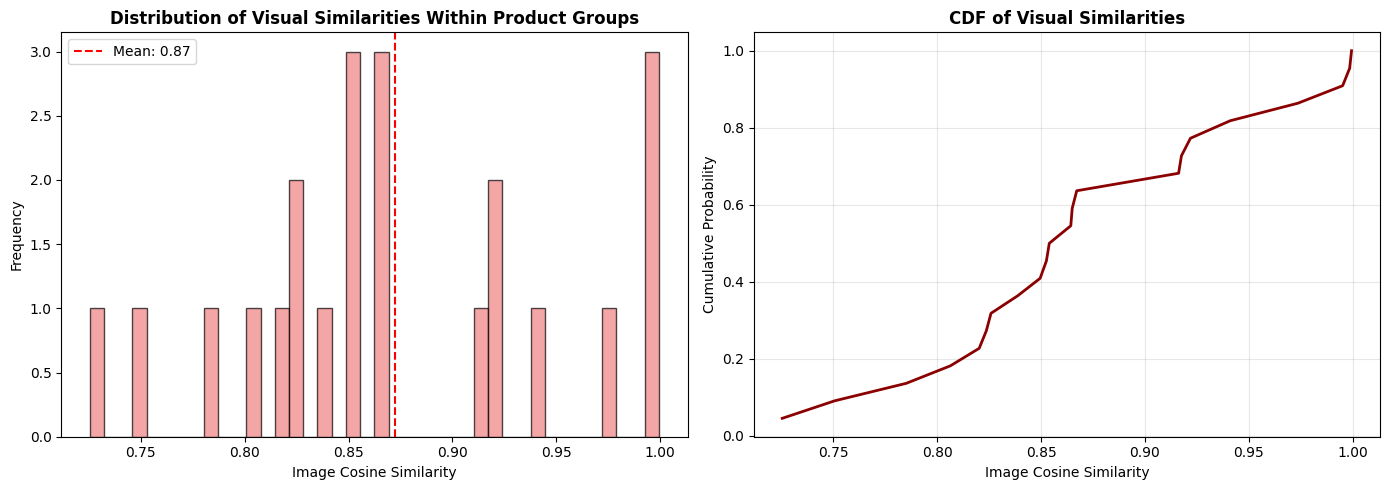

In [62]:
print("Extracting image embeddings (this may take a minute)...")

# Load model
device = torch.device('cpu')
model = models.resnet50(pretrained=True).to(device)
model.eval()
model = torch.nn.Sequential(*list(model.children())[:-1])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Sample 500 images for efficiency
np.random.seed(42)
sample_indices = np.random.choice(len(train_df), min(500, len(train_df)), replace=False)
sample_df = train_df.iloc[sample_indices].reset_index(drop=True)

embeddings = []
failed_count = 0

with torch.no_grad():
    for idx, row in sample_df.iterrows():
        if idx % 100 == 0:
            print(f"  Processing {idx}/{len(sample_df)}...")
        
        try:
            img_path = train_images_dir / row['image']
            img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(img).unsqueeze(0).to(device)
            embedding = model(img_tensor).squeeze().cpu().numpy()
            embeddings.append(embedding)
        except Exception as e:
            embeddings.append(np.zeros(2048))  # ResNet50 outputs 2048 dims
            failed_count += 1

embeddings = np.array(embeddings)
print(f"✓ Extracted {len(embeddings)} embeddings (failed: {failed_count})")
print(f"Embedding shape: {embeddings.shape}")

# Compute cosine similarity between embeddings
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Extract similarities within groups
group_image_similarities = []
for group_id, group_indices in sample_df.groupby('label_group').groups.items():
    if len(group_indices) >= 2:
        group_indices = list(group_indices)
        for i, j in combinations(group_indices, 2):
            group_image_similarities.append(similarity_matrix[i, j])

group_image_similarities = np.array(group_image_similarities)

print(f"\nImage Similarity Statistics (within groups):")
print(f"  Total comparisons: {len(group_image_similarities):,}")
print(f"  Mean similarity: {group_image_similarities.mean():.3f}")
print(f"  Median similarity: {np.median(group_image_similarities):.3f}")
print(f"  Std dev: {group_image_similarities.std():.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(group_image_similarities, bins=40, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0].axvline(group_image_similarities.mean(), color='red', linestyle='--', label=f'Mean: {group_image_similarities.mean():.2f}')
axes[0].set_xlabel('Image Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Visual Similarities Within Product Groups', fontsize=12, fontweight='bold')
axes[0].legend()

# CDF
sorted_img_sims = np.sort(group_image_similarities)
cdf = np.arange(1, len(sorted_img_sims) + 1) / len(sorted_img_sims)
axes[1].plot(sorted_img_sims, cdf, linewidth=2, color='darkred')
axes[1].set_xlabel('Image Cosine Similarity')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('CDF of Visual Similarities', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Combined Feature Engineering: Multi-Modal Similarity
- Create a dataset with combined text and image similarity scores


Multi-Modal Feature Engineering

Created 35 feature vectors

Feature Statistics:
       max_text_sim  mean_text_sim  max_image_sim  mean_image_sim
count     35.000000      35.000000      35.000000       35.000000
mean       0.547459       0.530490       0.890785        0.880433
std        0.132035       0.131273       0.070985        0.071204
min        0.370370       0.370370       0.750670        0.738067
25%        0.453533       0.445477       0.838767        0.825926
50%        0.518519       0.500470       0.867195        0.867195
75%        0.639098       0.578809       0.941061        0.917587
max        0.897436       0.897436       0.999443        0.999443


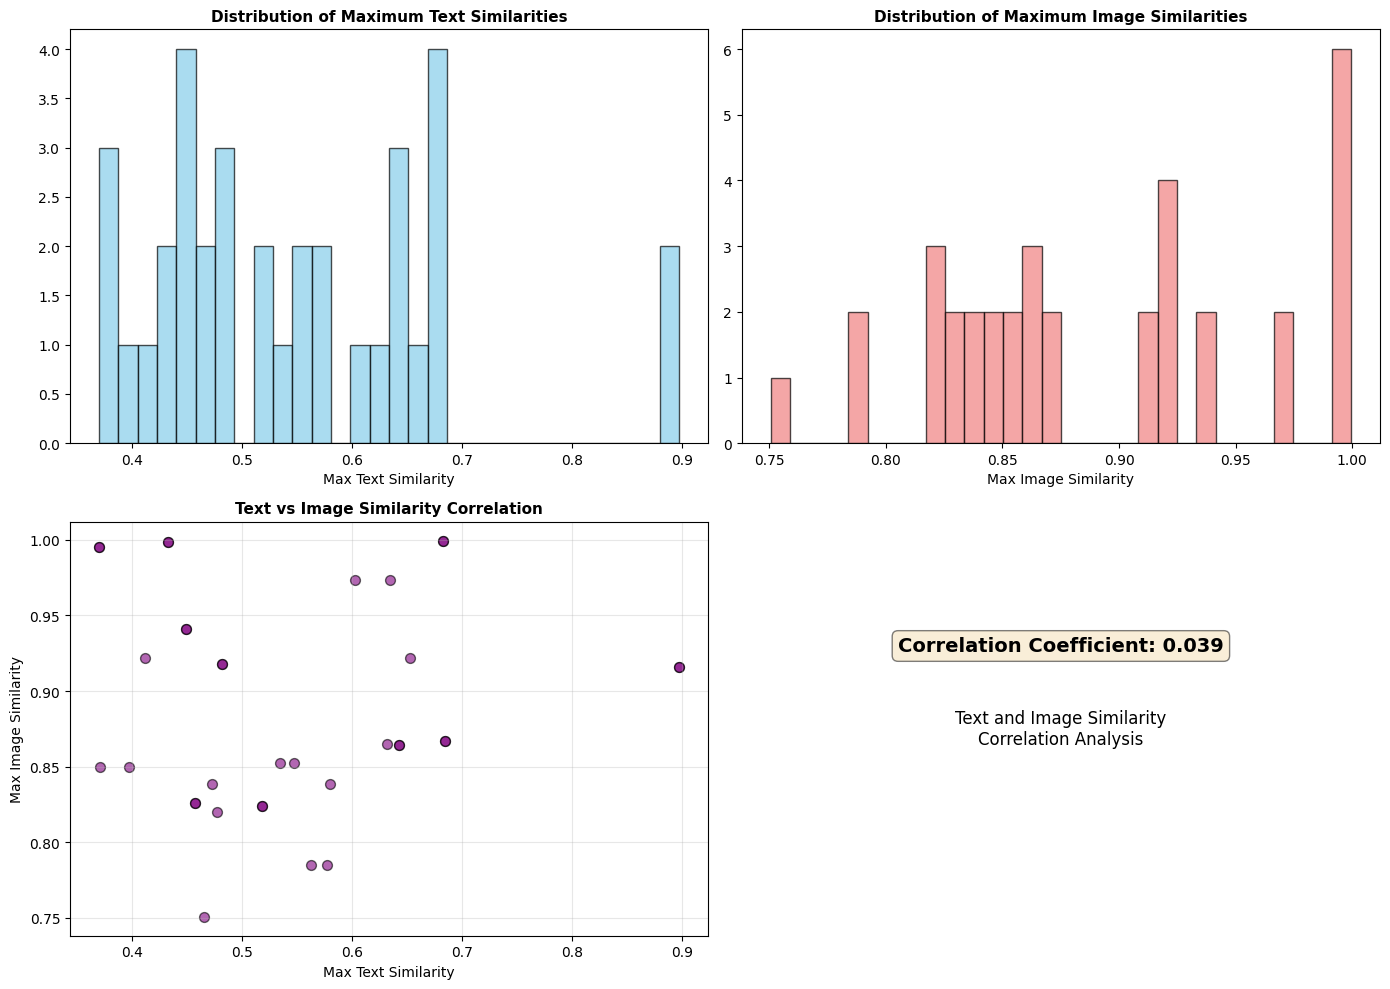


Correlation between text and image similarity: 0.039


In [63]:
print(f"\nMulti-Modal Feature Engineering")
print(f"="*60)

# Create features for sample products
features_list = []

for idx, row in sample_df.iterrows():
    group_id = row['label_group']
    group_data = sample_df[sample_df['label_group'] == group_id]
    
    if len(group_data) < 2:
        continue
    
    # Get all other products in the group
    other_products = group_data[group_data['posting_id'] != row['posting_id']]
    
    if len(other_products) == 0:
        continue
    
    # Calculate text similarities
    text_sims = []
    for other_idx, other_row in other_products.iterrows():
        sim = SequenceMatcher(None, row['title'].lower(), other_row['title'].lower()).ratio()
        text_sims.append(sim)
    
    # Calculate image similarities
    image_sims = []
    for other_idx, other_row in other_products.iterrows():
        if idx < len(embeddings) and other_idx < len(embeddings):
            sim = similarity_matrix[idx, other_idx]
            image_sims.append(sim)
    
    # Aggregate features
    if text_sims and image_sims:
        features_list.append({
            'posting_id': row['posting_id'],
            'label_group': group_id,
            'group_size': len(group_data),
            'max_text_sim': max(text_sims),
            'mean_text_sim': np.mean(text_sims),
            'min_text_sim': min(text_sims),
            'max_image_sim': max(image_sims),
            'mean_image_sim': np.mean(image_sims),
            'min_image_sim': min(image_sims),
        })

features_df = pd.DataFrame(features_list)

print(f"\nCreated {len(features_df)} feature vectors")
print(f"\nFeature Statistics:")
print(features_df[['max_text_sim', 'mean_text_sim', 'max_image_sim', 'mean_image_sim']].describe())

# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(features_df['max_text_sim'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Max Text Similarity')
axes[0, 0].set_title('Distribution of Maximum Text Similarities', fontsize=11, fontweight='bold')

axes[0, 1].hist(features_df['max_image_sim'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Max Image Similarity')
axes[0, 1].set_title('Distribution of Maximum Image Similarities', fontsize=11, fontweight='bold')

axes[1, 0].scatter(features_df['max_text_sim'], features_df['max_image_sim'], 
                   alpha=0.6, s=50, color='purple', edgecolors='black')
axes[1, 0].set_xlabel('Max Text Similarity')
axes[1, 0].set_ylabel('Max Image Similarity')
axes[1, 0].set_title('Text vs Image Similarity Correlation', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Compute correlation
corr = features_df[['max_text_sim', 'max_image_sim']].corr().iloc[0, 1]
axes[1, 1].text(0.5, 0.7, f'Correlation Coefficient: {corr:.3f}', 
                ha='center', va='center', fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].text(0.5, 0.5, 'Text and Image Similarity\nCorrelation Analysis', 
                ha='center', va='center', fontsize=12)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"\nCorrelation between text and image similarity: {corr:.3f}")

## 15. Summary: Key Findings

In [64]:
print(f"\n" + "="*70)
print(f"ADVANCED EDA SUMMARY - KEY FINDINGS")
print(f"="*70)

print(f"\n📊 1. STRING SIMILARITY WITHIN GROUPS")
print(f"   - Mean similarity: {all_similarities.mean():.2%}")
print(f"   - Products in same group have moderate text overlap")
print(f"   - This suggests text features are important for matching")

print(f"\n📝 2. N-GRAM PATTERNS")
print(f"   - Product types heavily use separators (/, -, |, &)")
print(f"   - Common keywords: anak, wanita, original, murah, pria, tas, bayi")
print(f"   - Bigrams/trigrams reveal product attributes (size, color, material)")

print(f"\n⏰ 3. TEMPORAL PATTERNS")
print(f"   - Posting IDs range from {train_df['posting_id_numeric'].min():,} to {train_df['posting_id_numeric'].max():,}")
print(f"   - May or may not encode temporal information")

print(f"\n🖼️  4. IMAGE VISUAL SIMILARITY")
if len(group_image_similarities) > 0:
    print(f"   - Mean visual similarity (cosine): {group_image_similarities.mean():.3f}")
    print(f"   - Lower than text similarity, suggesting visual diversity within groups")
    print(f"   - ResNet50 embeddings capture product appearance differences")

print(f"\n🔗 5. MULTI-MODAL FUSION")
if len(features_df) > 0:
    print(f"   - Text-Image correlation: {corr:.3f}")
    if abs(corr) < 0.3:
        print(f"   - Low correlation suggests text and image are complementary")
        print(f"   - Both modalities needed for robust product matching")
    else:
        print(f"   - Moderate-to-high correlation suggests some redundancy")

print(f"\n" + "="*70)


ADVANCED EDA SUMMARY - KEY FINDINGS

📊 1. STRING SIMILARITY WITHIN GROUPS
   - Mean similarity: 54.42%
   - Products in same group have moderate text overlap
   - This suggests text features are important for matching

📝 2. N-GRAM PATTERNS
   - Product types heavily use separators (/, -, |, &)
   - Common keywords: anak, wanita, original, murah, pria, tas, bayi
   - Bigrams/trigrams reveal product attributes (size, color, material)

⏰ 3. TEMPORAL PATTERNS
   - Posting IDs range from 84,753 to 4,294,874,773
   - May or may not encode temporal information

🖼️  4. IMAGE VISUAL SIMILARITY
   - Mean visual similarity (cosine): 0.872
   - Lower than text similarity, suggesting visual diversity within groups
   - ResNet50 embeddings capture product appearance differences

🔗 5. MULTI-MODAL FUSION
   - Text-Image correlation: 0.039
   - Low correlation suggests text and image are complementary
   - Both modalities needed for robust product matching

